# Decision trees and random forests

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar_train = dict(npz_file.items())
print('It is a dictionary with keys:', list(cifar_train.keys()))
#cifar_train  

It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Create X/y arrays
X = cifar_train['overfeat']
y = cifar_train['labels']
names = cifar_train['names']
pixels = cifar_train['pixels'].astype(np.float32)
pixels = pixels / 255

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)
print('pixels:', pixels.shape, pixels.dtype)
print('names:', names)

X: (5000, 4096) float32
y: (5000,) int64
pixels: (5000, 3072) float32
names: ['truck' 'car' 'airplane' 'ship']


In [3]:
# Reshape images: 32 by 32 with 3 (RGB) color channels
pixels_reshaped = pixels.reshape(-1, 32, 32, 3)
print('pixels_reshaped:', pixels_reshaped.shape, pixels_reshaped.dtype)
#print(pixels_reshaped)

pixels_reshaped: (5000, 32, 32, 3) float32


In [4]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float)

# Split data into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, train_size=4000, test_size=1000, random_state=0, stratify=y)
print('Train set:', X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)

Train set: (4000, 4096) (4000,)
Test set: (1000, 4096) (1000,)


In [5]:
# overfeat data: 176 values = 90% of the variance explained
from sklearn.preprocessing import StandardScaler
features=pd.DataFrame(X_tr) #convert to dataframe
# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_rescaled = scaler.fit_transform(X_tr)

# Create PCA transformer
pca_n = PCA(n_components=176)  #176 Components for Sum-PVE= 0.9001692523306701

# Apply PCA to rescaled data
X_2d_rescaled = pca_n.fit_transform(X_rescaled)
X_2d_rescaled_df=pd.DataFrame(X_2d_rescaled)
#print(X_2d_rescaled_df.head())

# Create DataFrame with variance and principal components
results_df2 = pd.DataFrame.from_items([
    ('variance', X_rescaled.var(axis=0)),
    ('1st component', pca_n.components_[0]),
    ('2nd component', pca_n.components_[1]),
    ('3nd component', pca_n.components_[2])
]).set_index(features.columns)

# Sort DataFrame by the coefficients of the 1st loading vector
#results_df2.sort_values('1st component', ascending=False).head()

C:\Users\x\Anaconda3\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


# first task: 
Create a decision tree classifier. Tune its depth and plot the validation curve

In [6]:
# Split data into train/validation sets
X_tr2, X_valid2, y_tr2, y_valid2 = train_test_split(
    X_2d_rescaled_df, y_tr, train_size=3200, test_size=800, random_state=0, stratify=y_tr)
print('Train set:', X_tr2.shape, y_tr2.shape)
print('Sub set:', X_valid2.shape, y_valid2.shape)

Train set: (3200, 176) (3200,)
Sub set: (800, 176) (800,)


In [7]:
# Create decision tree
from sklearn.tree import DecisionTreeClassifier
#  grid search
from sklearn.model_selection import ParameterGrid
Maximum_depth=15
depth_range = np.arange(1, Maximum_depth) 
grid = ParameterGrid({'max_depth': depth_range})
dt_test_scores = []

for i, params_dict  in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    dt_max_depth = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=0)

    # Fit decision tree
    dt_max_depth.fit(X_tr2, y_tr2)
        
    # Get train/test scores
    params_dict['Train_accuracy'] = dt_max_depth.score(X_tr2, y_tr2)
    params_dict['Valid_accuracy'] = dt_max_depth.score(X_valid2, y_valid2)
    print('Train accuracy: {:.3f}'.
          format(params_dict['Train_accuracy']),
          'Test accuracy: {:.3f}'
          .format(params_dict['Valid_accuracy']))

    # Save result
    dt_test_scores.append(params_dict)

print('done')

# Create DataFrame with scores
dt_test_scores_df=pd.DataFrame(dt_test_scores)
print(dt_test_scores_df)

Combination 1/14
Train accuracy: 0.452 Test accuracy: 0.449
Combination 2/14
Train accuracy: 0.619 Test accuracy: 0.604
Combination 3/14
Train accuracy: 0.648 Test accuracy: 0.639
Combination 4/14
Train accuracy: 0.676 Test accuracy: 0.634
Combination 5/14
Train accuracy: 0.700 Test accuracy: 0.646
Combination 6/14
Train accuracy: 0.753 Test accuracy: 0.644
Combination 7/14
Train accuracy: 0.799 Test accuracy: 0.630
Combination 8/14
Train accuracy: 0.845 Test accuracy: 0.621
Combination 9/14
Train accuracy: 0.892 Test accuracy: 0.594
Combination 10/14
Train accuracy: 0.927 Test accuracy: 0.591
Combination 11/14
Train accuracy: 0.953 Test accuracy: 0.583
Combination 12/14
Train accuracy: 0.970 Test accuracy: 0.569
Combination 13/14
Train accuracy: 0.981 Test accuracy: 0.574
Combination 14/14
Train accuracy: 0.988 Test accuracy: 0.580
done
    Train_accuracy  Valid_accuracy  max_depth
0         0.452188         0.44875          1
1         0.618750         0.60375          2
2         0.

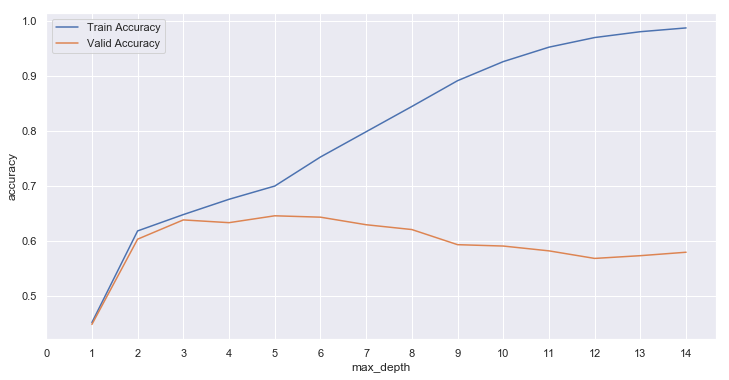

In [8]:
# Plot Validation curve
plt.figure( figsize=(12, 6))
plt.plot(dt_test_scores_df.max_depth, dt_test_scores_df.Train_accuracy, label='Train Accuracy')
plt.plot(dt_test_scores_df.max_depth, dt_test_scores_df.Valid_accuracy, label='Valid Accuracy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
# x-ticks  for single values
plt.xticks(np.arange(Maximum_depth), np.arange(Maximum_depth))
plt.legend()
plt.show()

-> observation: Training Accuracy is increasing towards 1.0, 
but Validation Accuracy is not increasing (slightly decreasing)

In [9]:
# Print maximum accuracy
#print(test_scores_df)
idx = dt_test_scores_df.Valid_accuracy.idxmax() # Index of maximum value
max_accuracy = dt_test_scores_df.Valid_accuracy[idx]
best_depth = dt_test_scores_df.max_depth[idx]
print('Top accuracy on validation set:  {:.3f} with depth {}'
      .format(max_accuracy, best_depth))

Top accuracy on validation set:  0.646 with depth 5


# second task
Create a random forest classifier. Try different sizes of ensemble.

In [10]:
import numpy as np

# Helper function
def decision_surface(x1, x2, y, estimator):
    # Create figure
    fig = plt.figure(figsize=(6, 6))
    axes = fig.gca() # Get the current axes

    # Same scale for x- and y-axis
    axes.set_aspect('equal', adjustable='box')

    # Plot data points
    class1_idx = (y == 1)

    plt.scatter(x1[class1_idx], x2[class1_idx],
        color=red, label='class 1')
    plt.scatter(x1[~class1_idx], x2[~class1_idx],
        color=blue, label='class 0')

    # Create a grid of values
    xlim, ylim = axes.get_xlim(), axes.get_ylim()
    x_values = np.linspace(*xlim, num=500)
    y_values = np.linspace(*ylim, num=500)
    xx, yy = np.meshgrid(x_values, y_values)
    grid_points = np.c_[xx.flatten(), yy.flatten()]

    # Compute predictions
    preds = estimator.predict(grid_points)
    zz = preds.reshape(xx.shape)

    # Draw decision boundary
    plt.contour(xx, yy, zz, levels=[0.5], colors='gray')

    # Plot decision surface
    plt.contourf(xx, yy, zz, alpha=0.1, cmap=plt.cm.coolwarm)

    # Show labels on a white frame
    plt.legend(frameon=True, facecolor='white')
    plt.show()

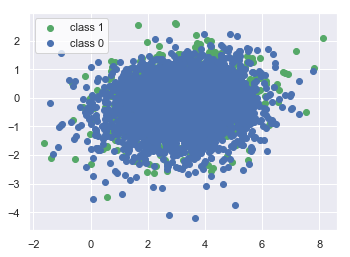

In [11]:
# Get a few colors from the default color palette
blue, green, red = sns.color_palette()[:3]

# Same scale for x- and y-axis
plt.gca().set_aspect('equal', adjustable='box')

# Plot data
class1_idx = (y == 1)

plt.scatter(X[:, 0][class1_idx], X[:, 1][class1_idx],
            c=red, label='class 1')
plt.scatter(X[:, 0][~class1_idx], X[:, 1][~class1_idx],
            c=blue, label='class 0')
# Show labels on a white frame
plt.legend(frameon=True, facecolor='white')
plt.show()

In [12]:
#  grid search
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
Maximum_estimators=250
depth_range = np.arange(10, Maximum_estimators,10) 
grid = ParameterGrid({'n_estimators': depth_range})
rf_test_scores=[]

for i, params_dict  in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    rf = RandomForestClassifier(n_estimators=i, max_depth=None, random_state=0)

    # Fit estimator
    rf.fit(X_tr2, y_tr2)
             
    # Get train/test scores
    params_dict['Train_accuracy'] = rf.score(X_tr2, y_tr2)
    params_dict['Valid_accuracy'] = rf.score(X_valid2, y_valid2)
    print('Train accuracy: {:.3f}'.
          format(params_dict['Train_accuracy']),
          'Test accuracy: {:.3f}'
          .format(params_dict['Valid_accuracy']))

    # Save result
    rf_test_scores.append(params_dict)

print('done')

# Create DataFrame with scores
rf_test_scores_df=pd.DataFrame(rf_test_scores)
print(rf_test_scores_df)

C:\Users\x\Anaconda3\envs\exts-aml2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Combination 1/24
Train accuracy: 0.820 Test accuracy: 0.496
Combination 2/24
Train accuracy: 0.790 Test accuracy: 0.431
Combination 3/24
Train accuracy: 0.904 Test accuracy: 0.497
Combination 4/24
Train accuracy: 0.932 Test accuracy: 0.536
Combination 5/24
Train accuracy: 0.958 Test accuracy: 0.549
Combination 6/24
Train accuracy: 0.973 Test accuracy: 0.560
Combination 7/24
Train accuracy: 0.983 Test accuracy: 0.586
Combination 8/24
Train accuracy: 0.987 Test accuracy: 0.583
Combination 9/24
Train accuracy: 0.992 Test accuracy: 0.588
Combination 10/24
Train accuracy: 0.993 Test accuracy: 0.605
Combination 11/24
Train accuracy: 0.997 Test accuracy: 0.629
Combination 12/24
Train accuracy: 0.998 Test accuracy: 0.621
Combination 13/24
Train accuracy: 0.998 Test accuracy: 0.634
Combination 14/24
Train accuracy: 0.998 Test accuracy: 0.655
Combination 15/24
Train accuracy: 0.999 Test accuracy: 0.656
Combination 16/24
Train accuracy: 0.999 Test accuracy: 0.659
Combination 17/24
Train accuracy:

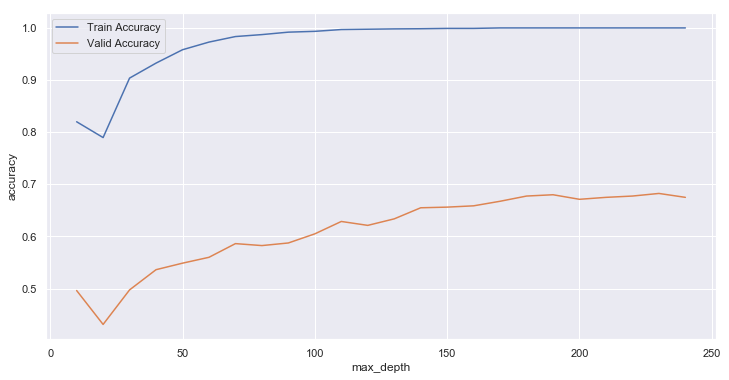

In [13]:
# Plot Validation curve
plt.figure( figsize=(12, 6))
plt.plot(rf_test_scores_df.n_estimators, rf_test_scores_df.Train_accuracy, label='Train Accuracy')
plt.plot(rf_test_scores_df.n_estimators, rf_test_scores_df.Valid_accuracy, label='Valid Accuracy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
# x-ticks  for single values
#plt.xticks(np.arange(Maximum_depth), np.arange(Maximum_depth))
plt.legend()
plt.show()

-> observation: Training Accuracy is increasing towards 1.0, 
but Validation Accuracy is not increasing anymore

In [14]:
# Print k with maximum accuracy
#print(test_scores_df)
idx = rf_test_scores_df.Valid_accuracy.idxmax() # Index of maximum value
max_accuracy = rf_test_scores_df.Valid_accuracy[idx]
best_estimators = rf_test_scores_df.n_estimators[idx]
print('Top accuracy on validation set:  {:.3f} with estimators {}'
      .format(max_accuracy, best_estimators))

Top accuracy on validation set:  0.682 with estimators 230


In [15]:
#In comparison with cross_validate
from sklearn.model_selection import cross_validate

# Mean test score of a single decision tree (max depth)
dt_scores = cross_validate(dt_max_depth, X_tr2, y_tr2, cv=10)
print('Decision tree - mean test {:.3f}'.format(
    np.mean(dt_scores['test_score'])))

# Mean test score of a random forest (200x, max depth)
rf_scores = cross_validate(rf, X_tr2, y_tr2, cv=10)
print('Random forest - mean test {:.3f}'.format(np.mean(rf_scores['test_score'])))

Decision tree - mean test 0.588
Random forest - mean test 0.689


# Third task
Finally, fit your (tuned) decision tree and random forest estimators on the entire train
set with 4,000 data points and evaluate them on the test set. Print the accuracy values

In [16]:
# Create decision tree
dt_best = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
# Fit decision tree
dt_best.fit(X_tr, y_tr)
dt_score=dt_best.score(X_te, y_te)
print('Decision tree accuracy (test set): ',dt_score)

Decision tree accuracy (test set):  0.658


In [17]:
#  Random forest
rf_best = RandomForestClassifier(n_estimators=170, max_depth=None, random_state=0)
# Fit estimator
rf_best.fit(X_tr, y_tr)
rf_score=rf_best.score(X_te, y_te)
print('Random forest accuracy (test set):',rf_score)

Random forest accuracy (test set): 0.797


In [18]:
# Load data & Save Results
Result_df = pd.read_csv('Result_df.csv')
print(Result_df.head(9))

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.797
4        svm rbf          0.842
5       logistic          0.810
6          fc nn          0.839
7            cnn          0.816


In [19]:
Result_df.iloc[1,1]=dt_score
Result_df.iloc[2,1]=rf_score
print(Result_df.head(9))
#Write Result as Dataframe to file
Result_df.to_csv('Result_df.csv', index=False, float_format='%.3f')

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.797
4        svm rbf          0.842
5       logistic          0.810
6          fc nn          0.839
7            cnn          0.816
